In [224]:
import os

os.listdir("/kaggle/input/aadhar-biometric-updates-raw-chunks-of-data")

['api_data_aadhar_biometric_500000_1000000.csv',
 'api_data_aadhar_biometric_0_500000.csv',
 'api_data_aadhar_biometric_1500000_1861108.csv',
 'api_data_aadhar_biometric_1000000_1500000.csv']

In [225]:
import pandas as pd
import os

dfs = []

for file in os.listdir("/kaggle/input/aadhar-biometric-updates-raw-chunks-of-data"):
    if file.lower().endswith(".csv"):
        print("Reading:", file)
        df = pd.read_csv(os.path.join("/kaggle/input/aadhar-biometric-updates-raw-chunks-of-data", file))
        dfs.append(df)

print("Number of files read:", len(dfs))

biometric_df = pd.concat(dfs, ignore_index=True)

biometric_df.head()


Reading: api_data_aadhar_biometric_500000_1000000.csv
Reading: api_data_aadhar_biometric_0_500000.csv
Reading: api_data_aadhar_biometric_1500000_1861108.csv
Reading: api_data_aadhar_biometric_1000000_1500000.csv
Number of files read: 4


,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,19-09-2025,Goa,North Goa,403502,0,4
1,19-09-2025,Goa,North Goa,403508,1,4
2,19-09-2025,Goa,North Goa,403513,2,0
3,19-09-2025,Goa,North Goa,403527,2,2
4,19-09-2025,Goa,South Goa,403601,7,3


In [226]:
biometric_df.shape

(1861108, 6)

In [227]:
biometric_df.columns

Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_'], dtype='object')

In [228]:
import pandas as pd

biometric_df['date'] = pd.to_datetime(
    biometric_df['date'],
    dayfirst=True,
    errors='coerce'
)
biometric_df['year'] = biometric_df['date'].dt.year
biometric_df['month'] = biometric_df['date'].dt.month
biometric_df[['date']].head()


,date
0,2025-09-19
1,2025-09-19
2,2025-09-19
3,2025-09-19
4,2025-09-19


Date fields were converted to datetime format using day-first parsing to correctly interpret the Indian date format (DD-MM-YYYY). Invalid entries were safely handled using coercion.

In [229]:
biometric_df['date'].dt.day.head()
biometric_df['date'].dt.month.head()

0    9
1    9
2    9
3    9
4    9
Name: date, dtype: int32

The correctness of date parsing was verified by extracting individual date components (date and month) from the datetime field.

In [230]:
biometric_df['total_bio_updates'] = (
    biometric_df['bio_age_5_17'] + biometric_df['bio_age_17_']
)

The biometric update dataset provides aggregated counts of Aadhaar holders who completed biometric updates, segmented by age group (5–17 years and 18 years and above), geography (state, district, PIN code), and date. Each value represents the number of biometric update events recorded for the specified age group in a given region and time period.

Total biometric updates were derived by summing age-wise update counts.

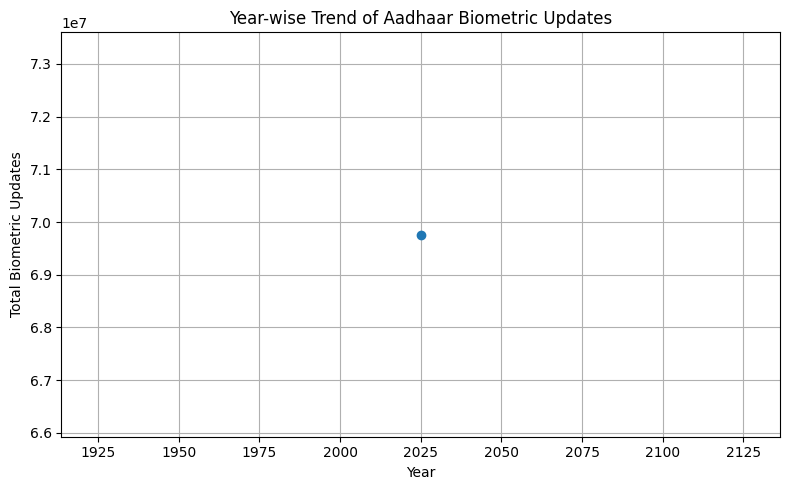

In [231]:
#year-wise totals
yearly_trend = (
    biometric_df
    .groupby('year')['total_bio_updates']
    .sum()
    .reset_index()
    .sort_values('year')
)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(
    yearly_trend['year'],
    yearly_trend['total_bio_updates'],
    marker='o'
)
plt.xlabel("Year")
plt.ylabel("Total Biometric Updates")
plt.title("Year-wise Trend of Aadhaar Biometric Updates")
plt.grid(True)
plt.tight_layout()
plt.show()

In [232]:
biometric_df['year'].unique()
biometric_df['year'].value_counts()
biometric_df['month'].unique()

array([ 9, 10, 11,  3,  4,  5,  6,  7, 12], dtype=int32)

The biometric update dataset corresponds to the year 2025 and spans multiple months. As the dataset does not cover a complete calendar year, temporal analysis was performed at a month-wise level for the available months.

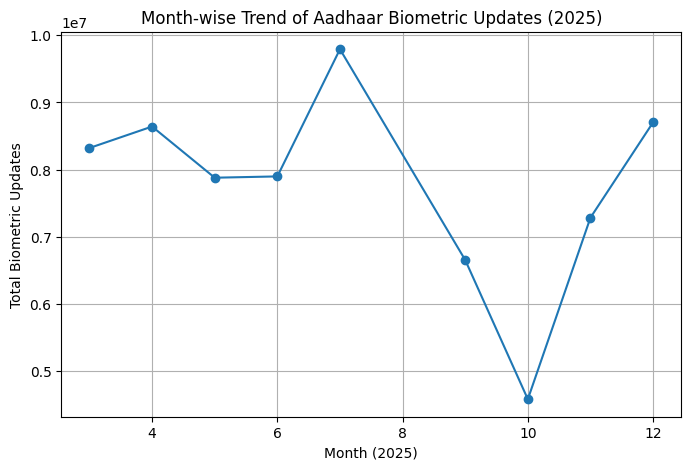

In [233]:
monthly_trend = (
    biometric_df
    .groupby('month')['total_bio_updates']
    .sum()
    .reset_index()
    .sort_values('month')
)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(
    monthly_trend['month'],
    monthly_trend['total_bio_updates'],
    marker='o'
)
plt.xlabel("Month (2025)")
plt.ylabel("Total Biometric Updates")
plt.title("Month-wise Trend of Aadhaar Biometric Updates (2025)")
plt.grid(True)
plt.show()


In [234]:
import calendar
peak_month = monthly_trend.loc[
    monthly_trend['total_bio_updates'].idxmax(), 'month'
]

low_month = monthly_trend.loc[
    monthly_trend['total_bio_updates'].idxmin(), 'month'
]

peak_month, low_month

peak_month_name = calendar.month_name[peak_month]
low_month_name = calendar.month_name[low_month]

peak_month_name, low_month_name

('July', 'October')

The plot above indicates periodic surges in biometric revalidation activity, potentially driven by age transitions, administrative drives, or increased citizen engagement.

**Why July might be high:**

- School and college admissions

- Post-summer administrative updates

- Mid-year outreach drives

**Why October might be low:**

- Festival season

- Reduced administrative activity

- Citizen postponement of updates


Analysis of Aadhaar biometric updates for 2025 shows clear month-wise variation. July recorded the highest 
biometric update activity, while October showed the lowest. This indicates non-uniform demand for biometric services across the year, 
suggesting the presence of seasonal factors influencing update behaviour.

In [235]:
monthly_trend['percentage_share'] = (
    monthly_trend['total_bio_updates'] /
    monthly_trend['total_bio_updates'].sum()
) * 100

monthly_trend

,month,total_bio_updates,percentage_share
0,3,8322222,11.929261
1,4,8641679,12.387178
2,5,7879956,11.295307
3,6,7899289,11.323020
4,7,9792552,14.036866
5,9,6654928,9.539324
6,10,4582655,6.568881
7,11,7285506,10.443209
8,12,8704308,12.476952


July alone contributes a disproportionately high share i.e. 14% of biometric updates in 2025, whereas October contributes the least i.e. 6.5%. This imbalance highlights the need for month-specific resource allocation rather than uniform staffing throughout the year.

In [236]:
monthly_age = (
    biometric_df
    .groupby('month')[['bio_age_5_17', 'bio_age_17_']]
    .sum()
    .reset_index()
    .sort_values('month')
)

In [237]:
#comparing age groups month wise

monthly_age['total_updates'] = (
    monthly_age['bio_age_5_17'] + monthly_age['bio_age_17_']
)

monthly_age['pct_age_5_17'] = (
    monthly_age['bio_age_5_17'] / monthly_age['total_updates']
) * 100

monthly_age['pct_age_17_plus'] = (
    monthly_age['bio_age_17_'] / monthly_age['total_updates']
) * 100

monthly_age

,month,bio_age_5_17,bio_age_17_,total_updates,pct_age_5_17,pct_age_17_plus
0,3,3733578,4588644,8322222,44.862754,55.137246
1,4,4356896,4284783,8641679,50.417240,49.582760
2,5,3868247,4011709,7879956,49.089703,50.910297
3,6,3710149,4189140,7899289,46.968139,53.031861
4,7,4499057,5293495,9792552,45.943662,54.056338
5,9,3610497,3044431,6654928,54.252984,45.747016
6,10,2215380,2367275,4582655,48.342718,51.657282
7,11,3608891,3676615,7285506,49.535214,50.464786
8,12,4624160,4080148,8704308,53.124958,46.875042


1. **Near-Equal Age Participation in Certain Months Indicates Balanced Demand :**
   In months such as April, May, and November, the percentage contribution of the 5–17 and 18+ age groups is nearly equal (≈50% each), suggesting     balanced biometric update demand across age groups during these periods.

2. **July Peak Is Driven by Both Age Groups, with Strong Adult Contribution :**
   July records the highest total biometric update volume (~9.8 million updates), with adults contributing approximately 54% and the 5–17 age         group contributing 46%. This demonstrates that the mid-year surge in biometric updates is driven by increased participation across all age         groups, particularly adults.


3. **October Decline Is System-Wide, Not Age-Specific :**
    October exhibits the lowest biometric update activity (~4.6 million updates), with both age groups showing reduced participation. The age-wise     percentage split remains balanced, indicating that the decline is not age-driven but likely influenced by seasonal or operational factors.


4. **Stable Age-Wise Percentage Pattern Enables Predictable Planning :**
    The percentage distribution between the 5–17 and 18+ age groups remains relatively stable across months, typically within a 45–55% range. This     stability indicates predictable biometric update behaviour across age groups, enabling UIDAI to plan infrastructure, staffing, and outreach        strategies proactively. Rather than redesigning age-specific interventions each month, resources can be scaled primarily based on overall          update volume while maintaining a consistent service mix for different age groups.

In [238]:
biometric_df.columns

Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_',
       'year', 'month', 'total_bio_updates'],
      dtype='object')

In [239]:
monthly_age['dominant_age_group'] = monthly_age.apply(
    lambda row: '18+' if row['bio_age_17_'] > row['bio_age_5_17'] else '5–17',
    axis=1
)

monthly_age[['month', 'dominant_age_group']]

,month,dominant_age_group
0,3,18+
1,4,5–17
2,5,18+
3,6,18+
4,7,18+
5,9,5–17
6,10,18+
7,11,18+
8,12,5–17


18+ age group dominates most months, whereas 5-17 dominates in fewer months like April, August and December.
5-17 spikes align with school/academic timelines like admissions/exams which need enrollment/ID updates. Adult updates cluster around mid-year and pre-festive which is consistent with travel/employment cycles.

### Regional Age-Wise Contributions Part

In [240]:
import re

biometric_df['state_norm'] = (
    biometric_df['state']
    .str.lower()
    .str.strip()
    .str.replace('&', 'and', regex=False)
    .str.replace(r'\s+', ' ', regex=True)
)

In [241]:
canonical_states = {
    # West Bengal
    'west bengal': 'West Bengal',
    'westbengal': 'West Bengal',
    'west bangal': 'West Bengal',

    # Odisha
    'orissa': 'Odisha',
    'odisha': 'Odisha',

    # Uttarakhand
    'uttaranchal': 'Uttarakhand',
    'uttarakhand': 'Uttarakhand',

    # Tamil Nadu
    'tamil nadu': 'Tamil Nadu',
    'tamilnadu': 'Tamil Nadu',

    # Puducherry
    'pondicherry': 'Puducherry',

    # Dadra & Nagar Haveli and Daman & Diu
    'dadra and nagar haveli': 'Dadra and Nagar Haveli and Daman and Diu',
    'daman and diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'dadra and nagar haveli and daman and diu':
        'Dadra and Nagar Haveli and Daman and Diu',

    # Andaman & Nicobar
    'andaman and nicobar islands': 'Andaman and Nicobar Islands',

    # Jammu & Kashmir
    'jammu and kashmir': 'Jammu and Kashmir',

    # Chhattisgarh
    'chhatisgarh': 'Chhattisgarh',
    'chhattisgarh': 'Chhattisgarh',
}


In [242]:
biometric_df['state_final'] = biometric_df['state_norm'].map(canonical_states)

# If state not in mapping, keep title-cased version
biometric_df['state_final'] = biometric_df['state_final'].fillna(
    biometric_df['state_norm'].str.title()
)

In [243]:
state_age_clean = (
    biometric_df
    .groupby('state_final')[['bio_age_5_17', 'bio_age_17_']]
    .sum()
    .reset_index()
)

state_age_clean['total_updates'] = (
    state_age_clean['bio_age_5_17'] +
    state_age_clean['bio_age_17_']
)

state_age_clean['pct_18_plus'] = (
    state_age_clean['bio_age_17_'] /
    state_age_clean['total_updates']
) * 100

state_age_clean['pct_5_17'] = (
    state_age_clean['bio_age_5_17'] /
    state_age_clean['total_updates']
) * 100

state_age_clean.sort_values('pct_18_plus', ascending=False)


,state_final,bio_age_5_17,bio_age_17_,total_updates,pct_18_plus,pct_5_17
24,Nagaland,32561,77032,109593,70.289161,29.710839
6,Chhattisgarh,884555,1764179,2648734,66.604612,33.395388
20,Maharashtra,3512712,5713427,9226139,61.926522,38.073478
26,Puducherry,27046,42862,69908,61.312010,38.687990
27,Punjab,700157,1039514,1739671,59.753482,40.246518
16,Kerala,647939,961791,1609730,59.748591,40.251409
35,West Bengal,1040512,1484107,2524619,58.785385,41.214615
7,Dadra and Nagar Haveli and Daman and Diu,16362,22906,39268,58.332484,41.667516
22,Meghalaya,36531,51095,87626,58.310319,41.689681
11,Haryana,693667,941787,1635454,57.585661,42.414339


**Note to M3**: Please use state_age_clean for cleaned state-wise update data.

States like Nagaland, Chhattisgarh and Maharashtra have strong dominance of adult biometric updates, indicating higher revalidation demand among the adults.<br>
States like Odisha, Goa, Tripura, Himachal Pradesh, and Ladakh exhibit nearly equal biometric update partcipation between 5-17 and 18+ age groups.<br>
Mizoram, Chandigarh, UP and Assam show higher activity among 5-17 age groups, which might suggest school-age or youth-driven revalidation patterns.<br>
The wide variation in age-wise biometric update percentages across states (≈30%–70%) indicates that a uniform, nationwide approach to biometric update planning may be inefficient, underscoring the need for state-tailored outreach and resource allocation.

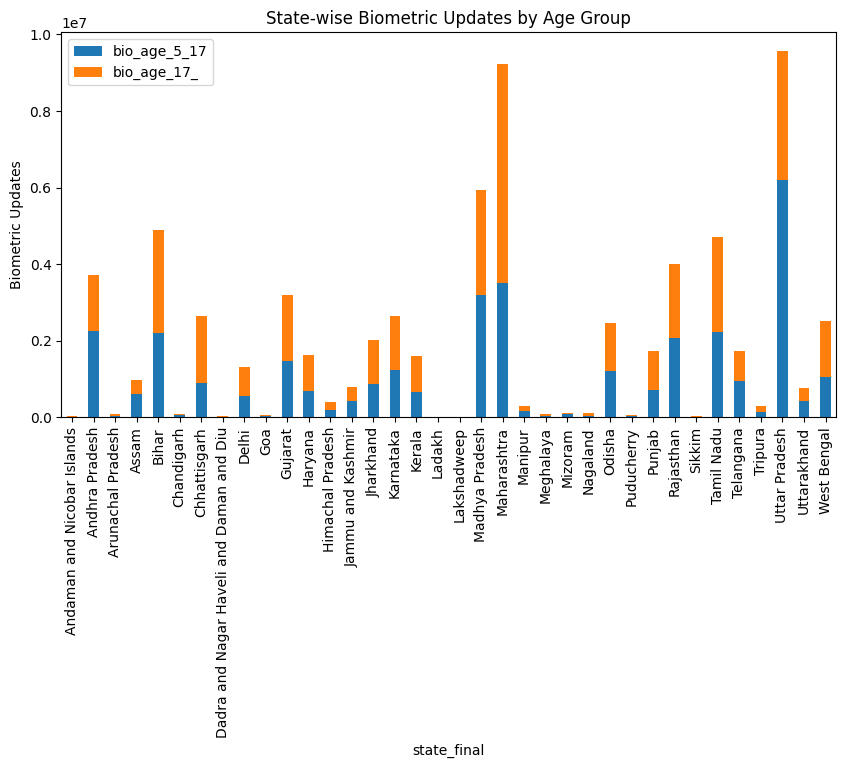

In [244]:
state_age_clean.set_index('state_final')[['bio_age_5_17', 'bio_age_17_']].plot(
    kind='bar',
    stacked=True,
    figsize=(10,5)
)
plt.ylabel("Biometric Updates")
plt.title("State-wise Biometric Updates by Age Group")
plt.show()

In [245]:
#M3
import pandas as pd
import numpy as np

state_age_clean.info()
state_age_clean.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   state_final    36 non-null     object 
 1   bio_age_5_17   36 non-null     int64  
 2   bio_age_17_    36 non-null     int64  
 3   total_updates  36 non-null     int64  
 4   pct_18_plus    36 non-null     float64
 5   pct_5_17       36 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 1.8+ KB


,state_final,bio_age_5_17,bio_age_17_,total_updates,pct_18_plus,pct_5_17
0,Andaman and Nicobar Islands,11806,8892,20698,42.960673,57.039327
1,Andhra Pradesh,2241467,1473166,3714633,39.658453,60.341547
2,Arunachal Pradesh,42894,29500,72394,40.749233,59.250767
3,Assam,596624,386098,982722,39.288629,60.711371
4,Bihar,2208141,2689446,4897587,54.913695,45.086305


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

In [247]:
#defining the metrics for regional outliers 
metrics = [
    "pct_5_17",
    "pct_18_plus",
    "total_updates"
]


In [248]:
#computing the sate wise outliers so with the help of z score
outlier_df = state_age_clean.copy()

for col in metrics:
    outlier_df[f"{col}_z"] = zscore(outlier_df[col])


In [249]:
'''flagging regional outliers'''
THRESHOLD = 2.5

for col in metrics:
    outlier_df[f"{col}_outlier"] = (
        outlier_df[f"{col}_z"].abs() > THRESHOLD
    )


In [250]:
outlier_df["regional_outlier"] = (
    outlier_df[[f"{c}_outlier" for c in metrics]]
    .any(axis=1)
)
#consolidated the regional outliers and executing the deliverables in the next cell


In [251]:
#extracting the regional outliers 
regional_outliers = outlier_df[outlier_df["regional_outlier"]]

regional_outliers[
    [
        "state_final",
        "pct_5_17",
        "pct_18_plus",
        "total_updates",
        "pct_5_17_z",
        "pct_18_plus_z",
        "total_updates_z"
    ]
].sort_values(
    by="total_updates_z", ascending=False
)


,state_final,pct_5_17,pct_18_plus,total_updates,pct_5_17_z,pct_18_plus_z,total_updates_z
33,Uttar Pradesh,64.807650,35.192350,9577735,1.706439,-1.706439,3.171689
20,Maharashtra,38.073478,61.926522,9226139,-1.215077,1.215077,3.025724


In [252]:
regional_outliers.to_csv(
    "M3_regional_outliers_state_level.csv",
    index=False
)


In [253]:
'''what did M3 DO '''
'''“The state_age_clean dataset is cross-sectional and does not contain a temporal dimension. 
Therefore, M3 anomaly detection focuses on identifying regional outliers based on deviations in age-group participation shares and total biometric update volumes. 
Temporal anomalies are handled separately using time-series datasets.”'''

'“The state_age_clean dataset is cross-sectional and does not contain a temporal dimension. \nTherefore, M3 anomaly detection focuses on identifying regional outliers based on deviations in age-group participation shares and total biometric update volumes. \nTemporal anomalies are handled separately using time-series datasets.”'

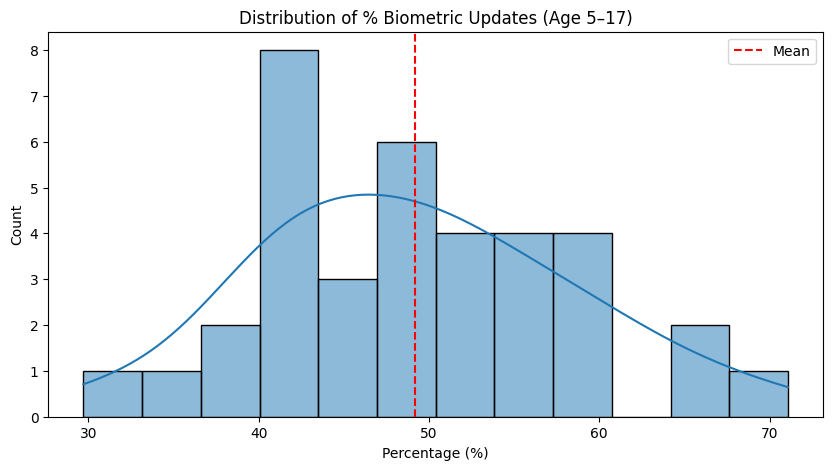

In [254]:
#graphs for visualistion 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(state_age_clean["pct_5_17"], bins=12, kde=True)
plt.axvline(state_age_clean["pct_5_17"].mean(), color="red", linestyle="--", label="Mean")
plt.title("Distribution of % Biometric Updates (Age 5–17)")
plt.xlabel("Percentage (%)")
plt.legend()
plt.show()


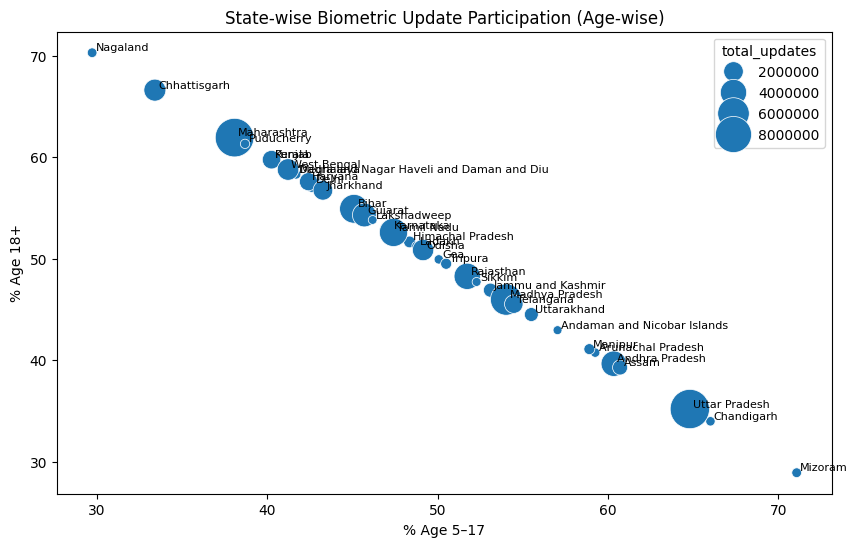

In [255]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=state_age_clean,
    x="pct_5_17",
    y="pct_18_plus",
    size="total_updates",
    sizes=(40, 800)
)

for i, row in state_age_clean.iterrows():
    plt.text(
        row["pct_5_17"] + 0.2,
        row["pct_18_plus"] + 0.2,
        row["state_final"],
        fontsize=8
    )

plt.title("State-wise Biometric Update Participation (Age-wise)")
plt.xlabel("% Age 5–17")
plt.ylabel("% Age 18+")
plt.show()


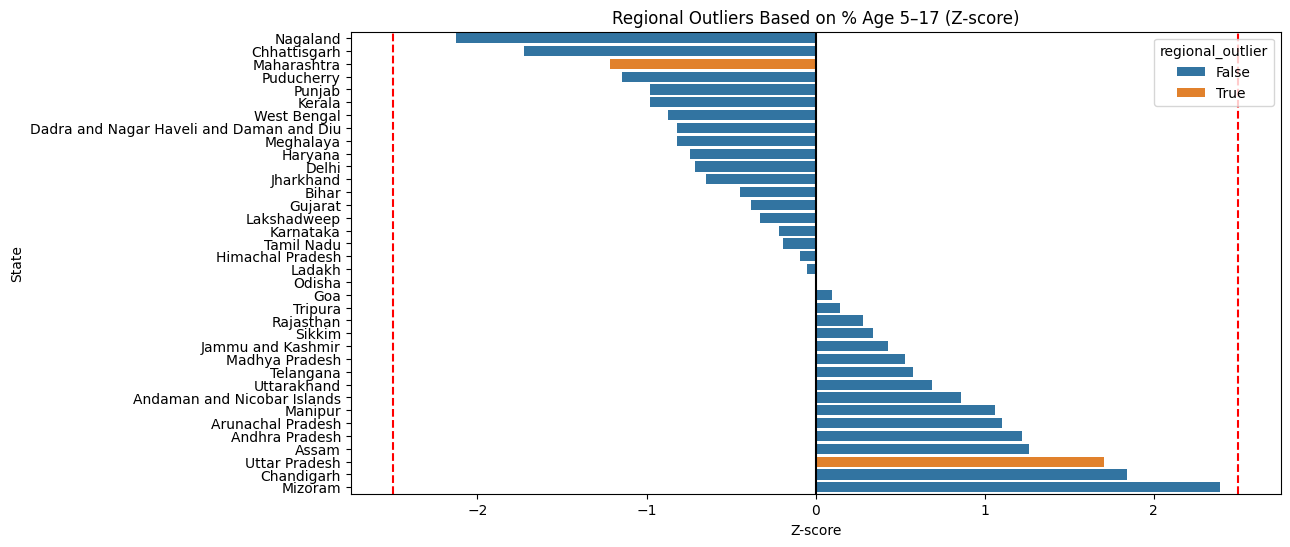

In [256]:
plt.figure(figsize=(12,6))

sns.barplot(
    data=outlier_df.sort_values("pct_5_17_z"),
    x="pct_5_17_z",
    y="state_final",
    hue="regional_outlier",
    dodge=False
)

plt.axvline(0, color="black")
plt.axvline(2.5, color="red", linestyle="--")
plt.axvline(-2.5, color="red", linestyle="--")

plt.title("Regional Outliers Based on % Age 5–17 (Z-score)")
plt.xlabel("Z-score")
plt.ylabel("State")
plt.show()


In [265]:
import pandas as pd
import numpy as np

df_raw = df.copy()   # df = your current dataframe

state_age_clean = (
    df_raw
    .groupby("state")[["bio_age_5_17", "bio_age_17_"]]
    .sum()
    .reset_index()
)


state_age_clean["total_updates"] = (
    state_age_clean["bio_age_5_17"] +
    state_age_clean["bio_age_17_"]
)

state_age_clean["pct_5_17"] = (
    state_age_clean["bio_age_5_17"] /
    state_age_clean["total_updates"]
) * 100

state_age_clean["pct_18_plus"] = (
    state_age_clean["bio_age_17_"] /
    state_age_clean["total_updates"]
) * 100


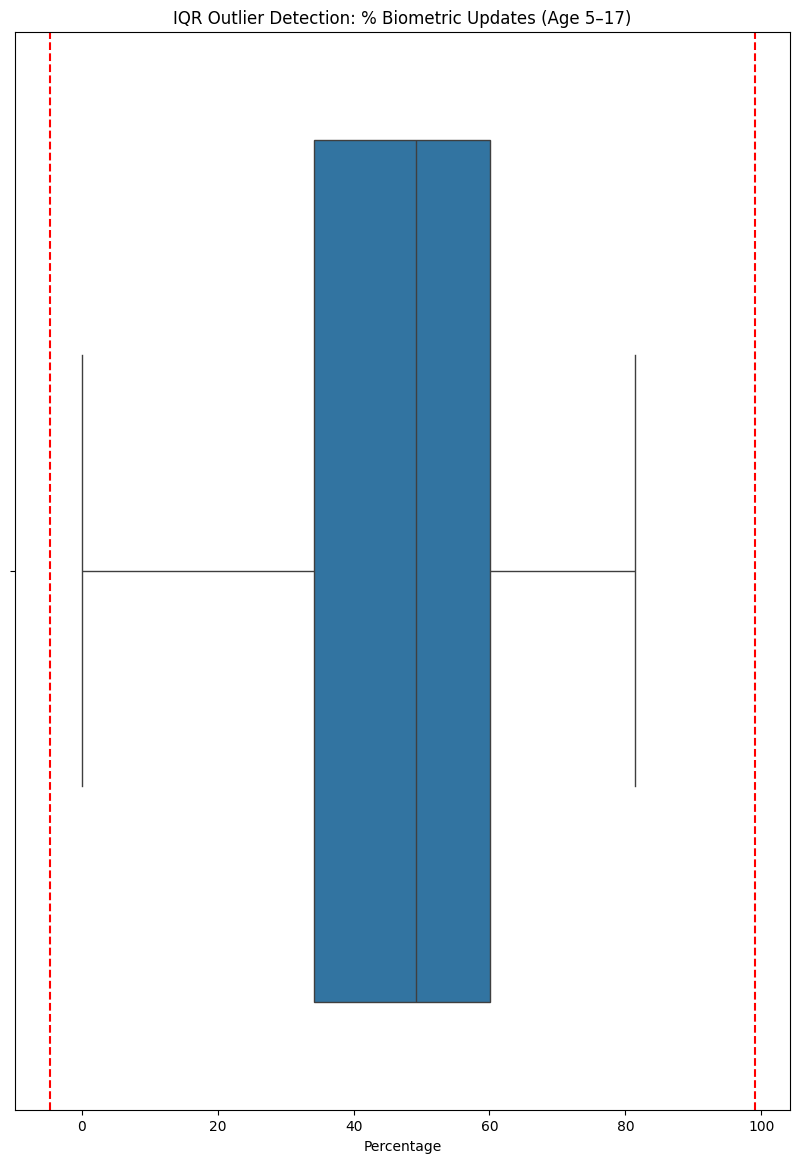

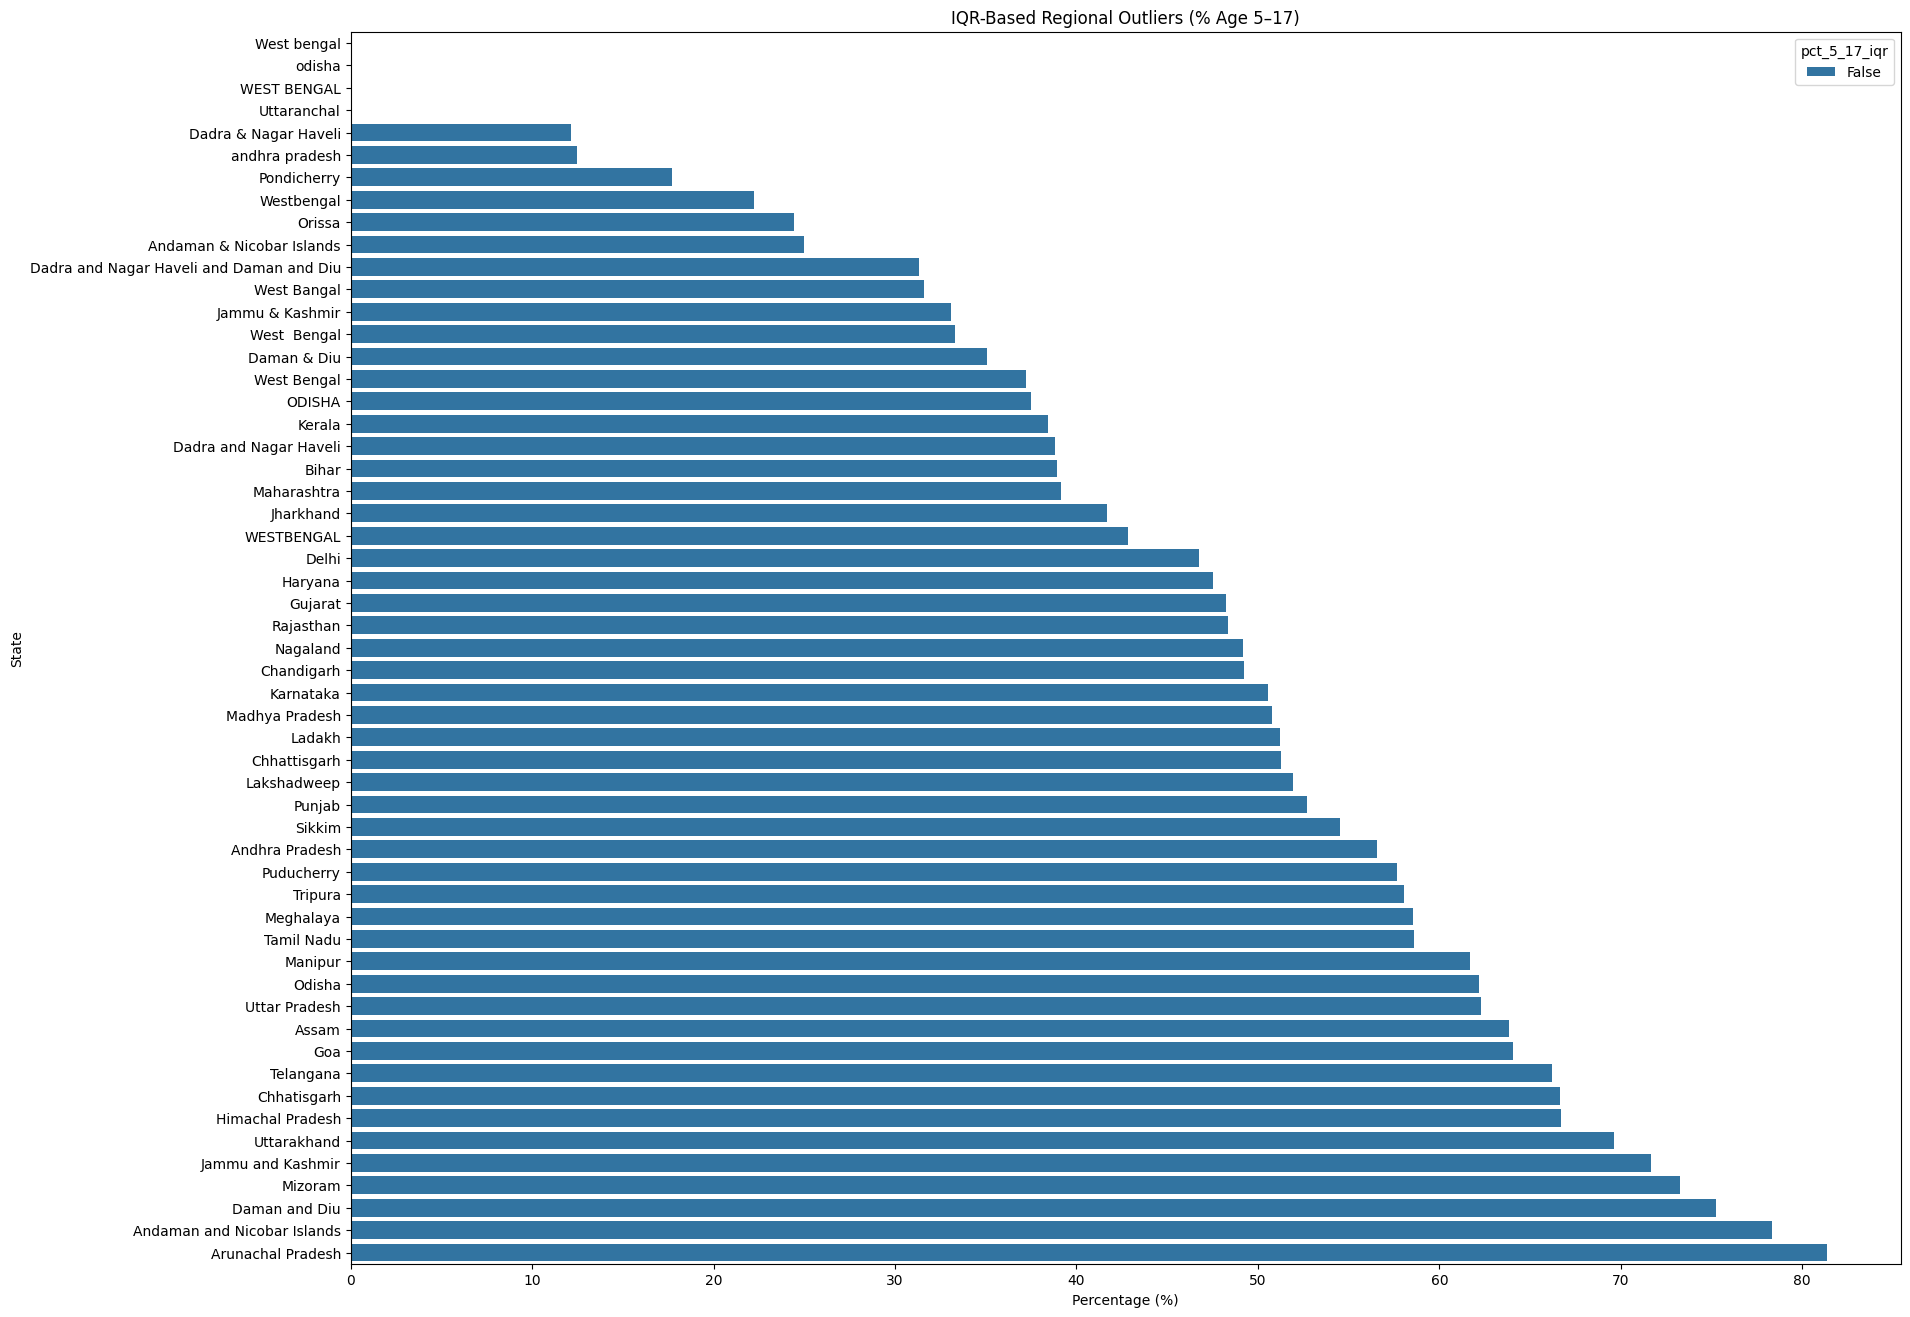

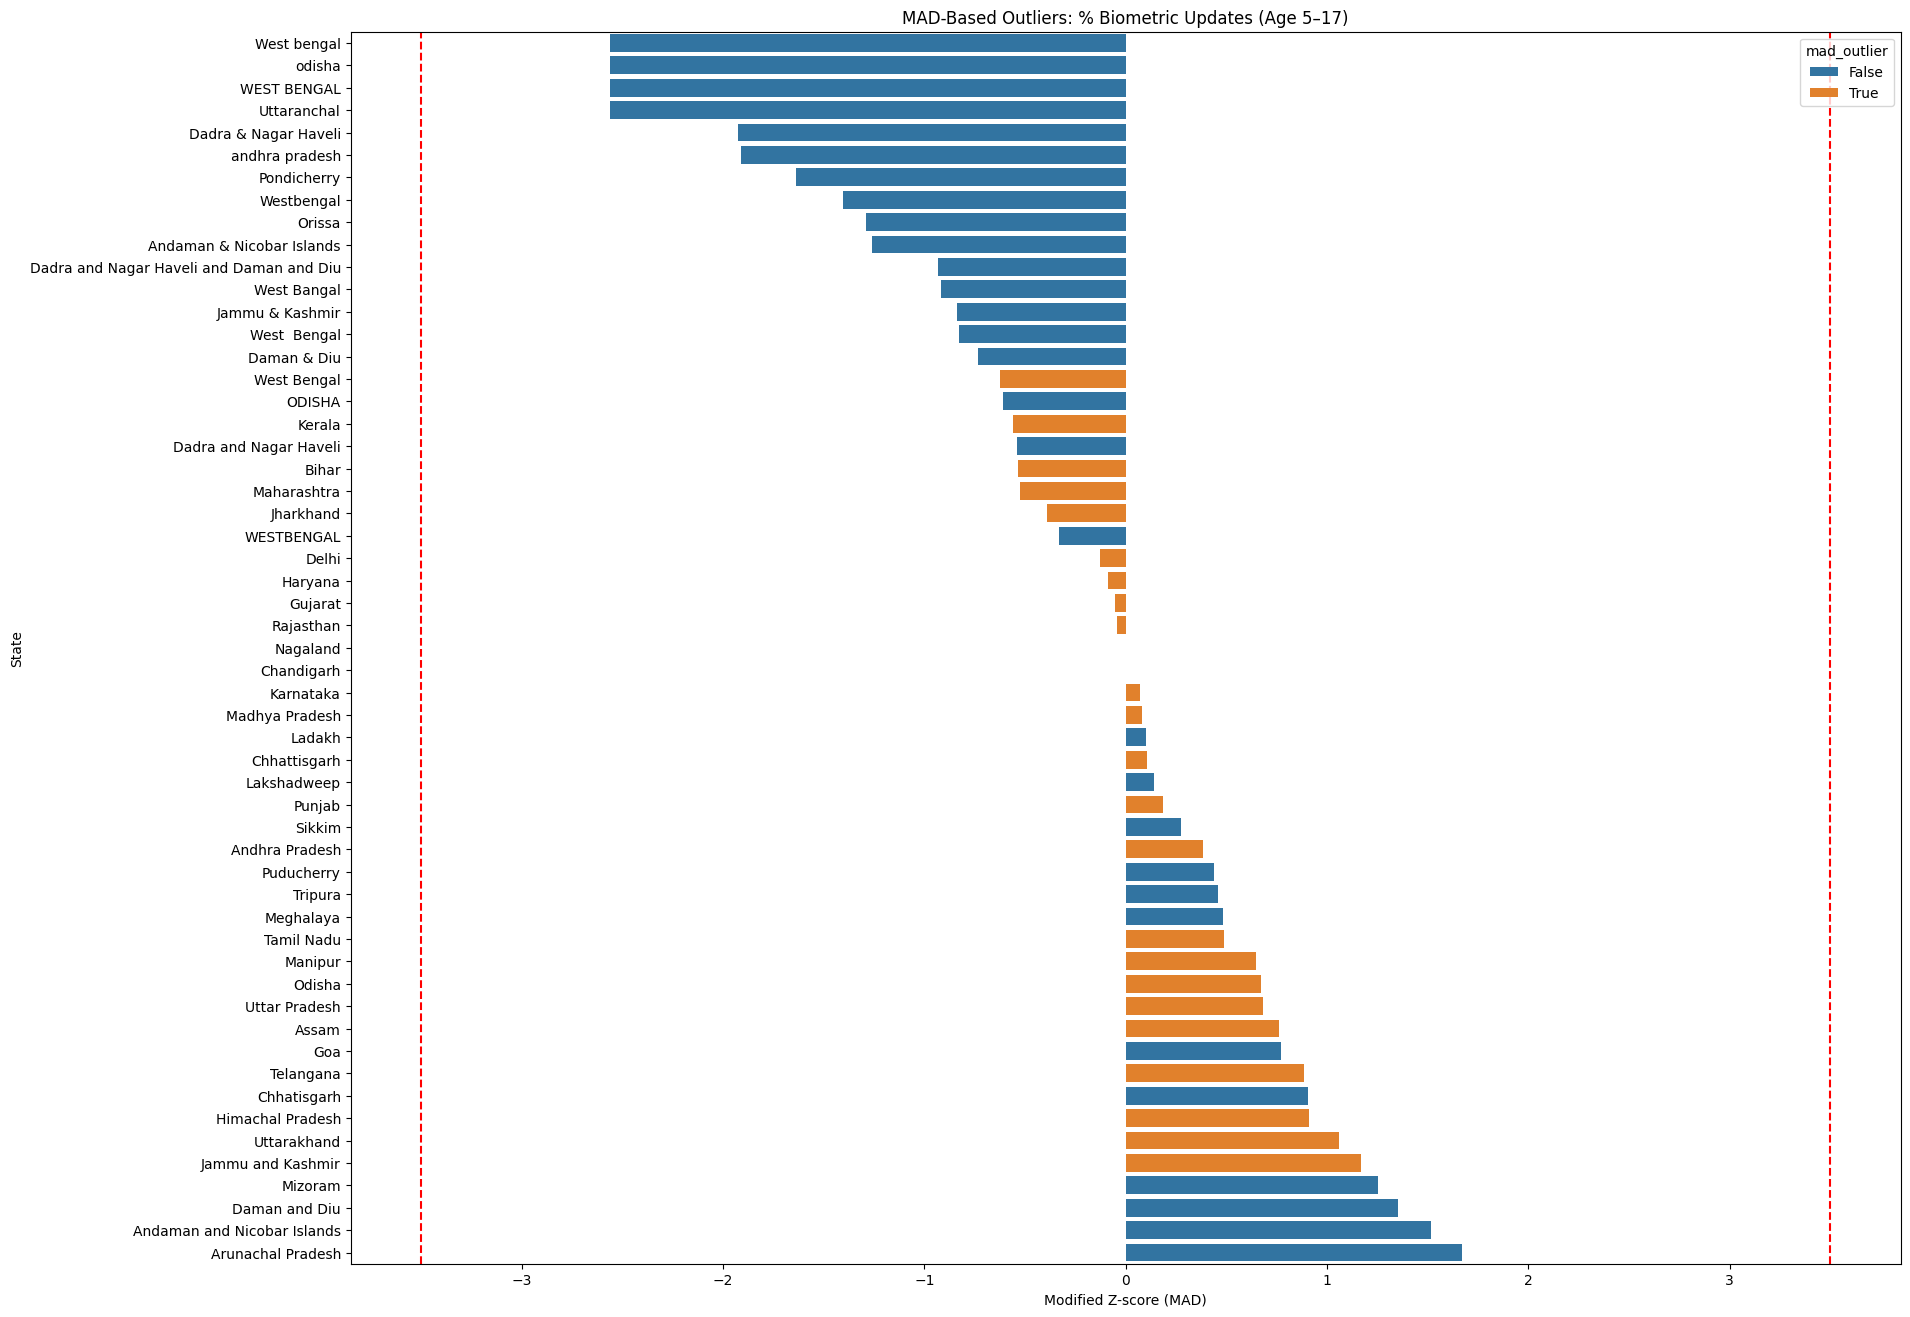

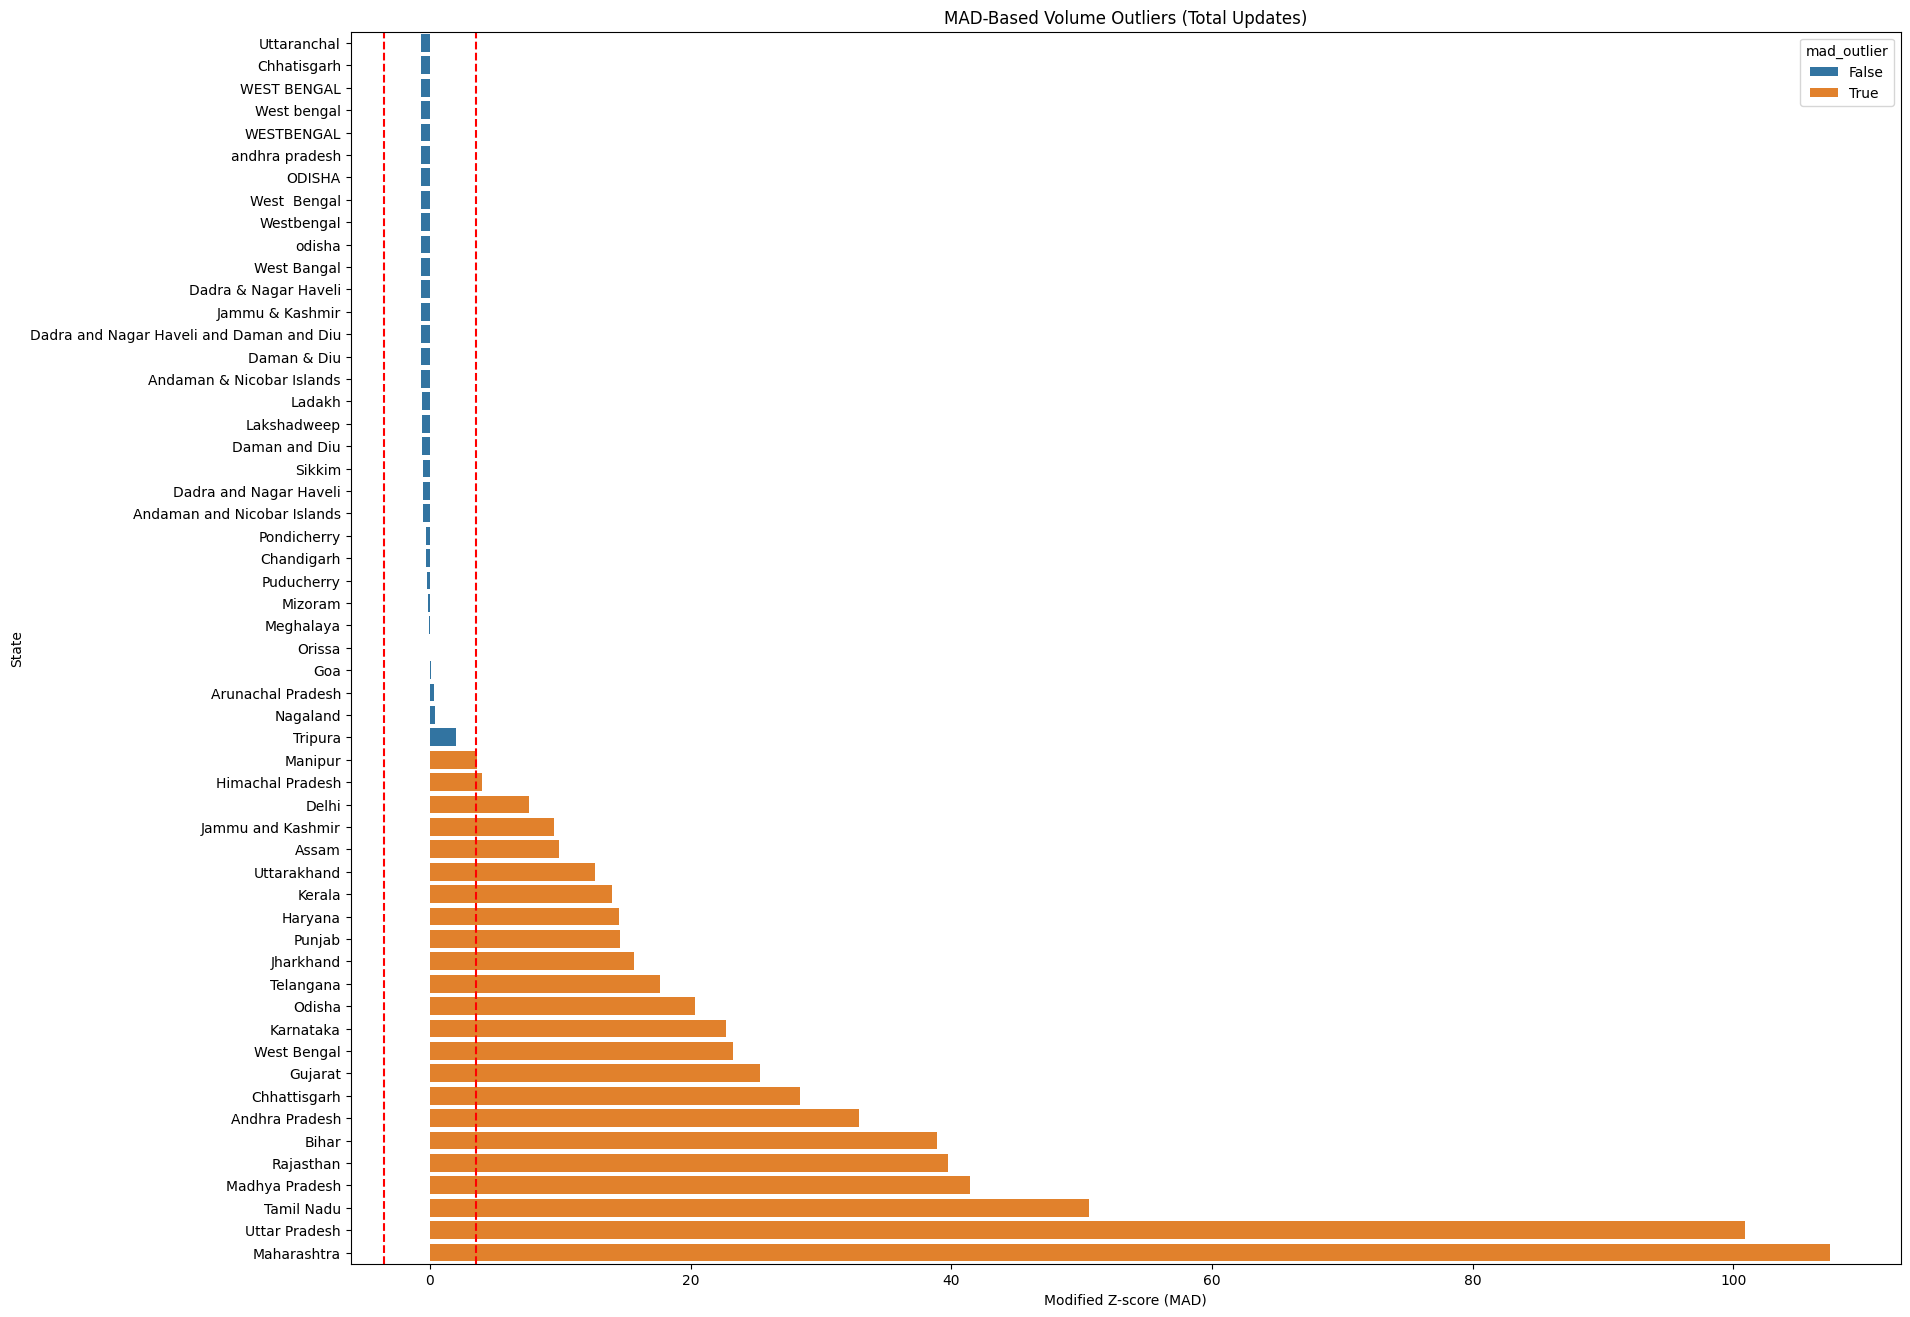

In [269]:
# ============================================================
# M3: Regional Anomaly Detection (Z-score + IQR + MAD)
# Dataset: state_age_clean (STATE-LEVEL AGGREGATED)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# ------------------------------------------------------------
# STEP 1: Working copy
# ------------------------------------------------------------
df = state_age_clean.copy()

# ------------------------------------------------------------
# STEP 2: Z-SCORE METHOD
# ------------------------------------------------------------
metrics = ["pct_5_17", "pct_18_plus", "total_updates"]

for col in metrics:
    df[f"{col}_z"] = zscore(df[col])

Z_THRESHOLD = 2.5

for col in metrics:
    df[f"{col}_z_outlier"] = df[f"{col}_z"].abs() > Z_THRESHOLD

df["zscore_outlier"] = df[[f"{c}_z_outlier" for c in metrics]].any(axis=1)

# ------------------------------------------------------------
# STEP 3: IQR METHOD
# ------------------------------------------------------------
def iqr_outlier(series, k=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return (series < lower) | (series > upper), lower, upper

df["pct_5_17_iqr"], low_5_17, high_5_17 = iqr_outlier(df["pct_5_17"])
df["pct_18_plus_iqr"], low_18p, high_18p = iqr_outlier(df["pct_18_plus"])
df["total_updates_iqr"], low_vol, high_vol = iqr_outlier(df["total_updates"])

df["iqr_outlier"] = (
    df["pct_5_17_iqr"] |
    df["pct_18_plus_iqr"] |
    df["total_updates_iqr"]
)

# ------------------------------------------------------------
# STEP 4: MAD (MODIFIED Z-SCORE) METHOD
# ------------------------------------------------------------
def modified_z_score(series):
    median = np.median(series)
    mad = np.median(np.abs(series - median))
    if mad == 0:
        return np.zeros(len(series))
    return 0.6745 * (series - median) / mad

df["pct_5_17_mad"] = modified_z_score(df["pct_5_17"])
df["pct_18_plus_mad"] = modified_z_score(df["pct_18_plus"])
df["total_updates_mad"] = modified_z_score(df["total_updates"])

MAD_THRESHOLD = 3.5

df["mad_outlier"] = (
    (df["pct_5_17_mad"].abs() > MAD_THRESHOLD) |
    (df["pct_18_plus_mad"].abs() > MAD_THRESHOLD) |
    (df["total_updates_mad"].abs() > MAD_THRESHOLD)
)

# ------------------------------------------------------------
# STEP 5: FINAL CONSENSUS FLAG
# ------------------------------------------------------------
df["final_regional_outlier"] = (
    df["zscore_outlier"] |
    df["iqr_outlier"] |
    df["mad_outlier"]
)

# ------------------------------------------------------------
# STEP 6: SAVE CSV DELIVERABLES
# ------------------------------------------------------------
df[df["zscore_outlier"]].to_csv("M3_regional_outliers_ZSCORE.csv", index=False)
df[df["iqr_outlier"]].to_csv("M3_regional_outliers_IQR.csv", index=False)
df[df["mad_outlier"]].to_csv("M3_regional_outliers_MAD.csv", index=False)
df[df["final_regional_outlier"]].to_csv("M3_regional_outliers_FINAL.csv", index=False)

# ------------------------------------------------------------
# STEP 7: GRAPHS
# ------------------------------------------------------------

# === GRAPH 1: IQR Boxplot (% Age 5–17)
plt.figure(figsize=(10,14))
sns.boxplot(x=df["pct_5_17"])
plt.axvline(low_5_17, color="red", linestyle="--")
plt.axvline(high_5_17, color="red", linestyle="--")
plt.title("IQR Outlier Detection: % Biometric Updates (Age 5–17)")
plt.xlabel("Percentage")
plt.show()

# === GRAPH 2: IQR State-wise Bar Plot
plt.figure(figsize=(20,16))
sns.barplot(
    data=df.sort_values("pct_5_17"),
    x="pct_5_17",
    y="state",
    hue="pct_5_17_iqr",
    dodge=False
)
plt.title("IQR-Based Regional Outliers (% Age 5–17)")
plt.xlabel("Percentage (%)")
plt.ylabel("State")
plt.show()

# === GRAPH 3: MAD Bar Plot (% Age 5–17)
plt.figure(figsize=(20,16))
sns.barplot(
    data=df.sort_values("pct_5_17_mad"),
    x="pct_5_17_mad",
    y="state",
    hue="mad_outlier",
    dodge=False
)
plt.axvline(MAD_THRESHOLD, color="red", linestyle="--")
plt.axvline(-MAD_THRESHOLD, color="red", linestyle="--")
plt.title("MAD-Based Outliers: % Biometric Updates (Age 5–17)")
plt.xlabel("Modified Z-score (MAD)")
plt.ylabel("State")
plt.show()

# === GRAPH 4: MAD Volume Anomalies
plt.figure(figsize=(20,16))
sns.barplot(
    data=df.sort_values("total_updates_mad"),
    x="total_updates_mad",
    y="state",
    hue="mad_outlier",
    dodge=False
)
plt.axvline(MAD_THRESHOLD, color="red", linestyle="--")
plt.axvline(-MAD_THRESHOLD, color="red", linestyle="--")
plt.title("MAD-Based Volume Outliers (Total Updates)")
plt.xlabel("Modified Z-score (MAD)")
plt.ylabel("State")
plt.show()


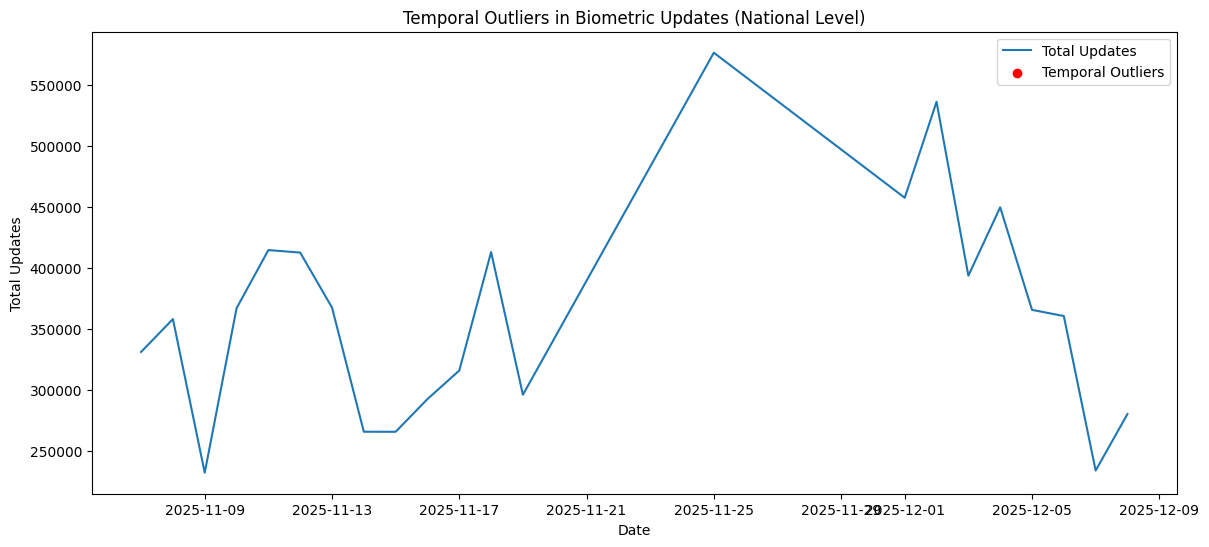

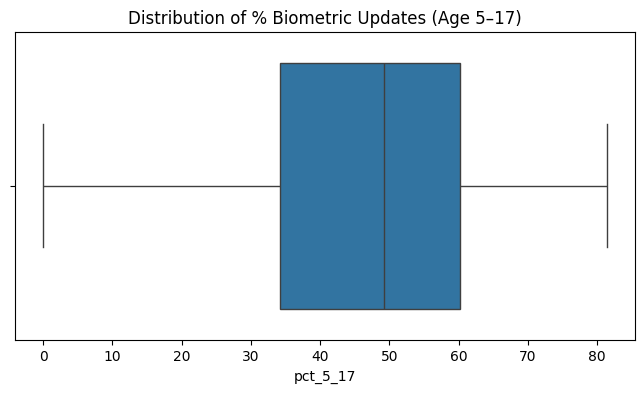

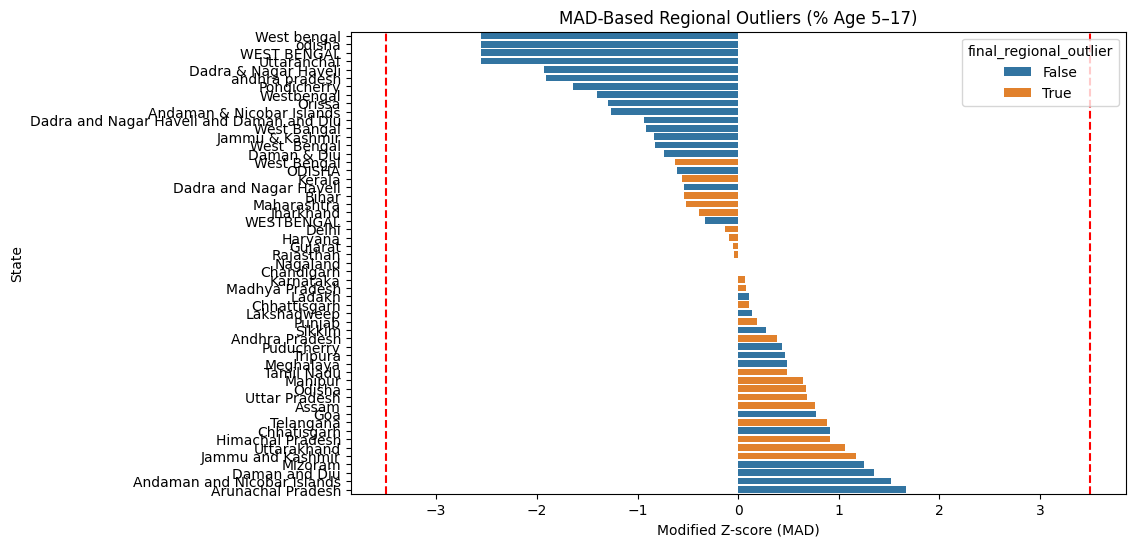

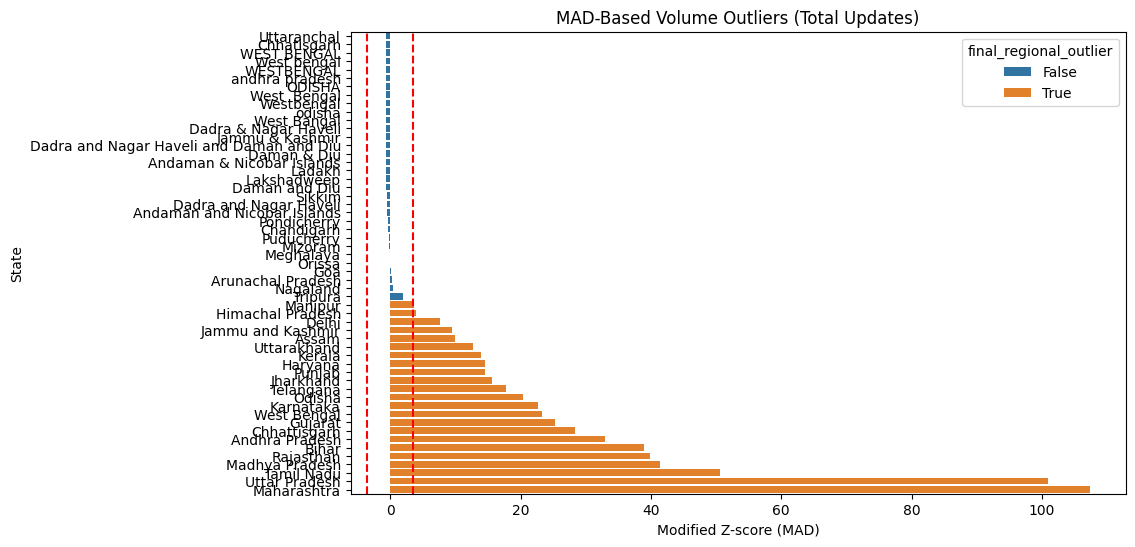

In [271]:
# ============================================================
# M3: TEMPORAL + REGIONAL ANOMALY DETECTION
# Methods: Z-score, IQR, MAD
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# ============================================================
# PART 0 — DATE FIX (CRITICAL)
# ============================================================

df_raw["date"] = pd.to_datetime(
    df_raw["date"],
    dayfirst=True,
    errors="coerce"
)

# ============================================================
# PART 1 — TEMPORAL OUTLIERS (NATIONAL LEVEL)
# ============================================================

temporal_df = (
    df_raw
    .groupby("date")[["bio_age_5_17", "bio_age_17_"]]
    .sum()
    .reset_index()
)

temporal_df["total_updates"] = (
    temporal_df["bio_age_5_17"] +
    temporal_df["bio_age_17_"]
)

temporal_df = temporal_df.sort_values("date")

# ---- Rolling baseline
WINDOW = 7

temporal_df["rolling_mean"] = (
    temporal_df["total_updates"]
    .rolling(WINDOW, center=True)
    .mean()
)

temporal_df["rolling_std"] = (
    temporal_df["total_updates"]
    .rolling(WINDOW, center=True)
    .std()
)

# ---- Z-score temporal outliers
temporal_df["temporal_z"] = (
    (temporal_df["total_updates"] - temporal_df["rolling_mean"]) /
    temporal_df["rolling_std"]
)

temporal_df["z_temporal_outlier"] = temporal_df["temporal_z"].abs() > 3

# ---- IQR temporal outliers
Q1 = temporal_df["total_updates"].quantile(0.25)
Q3 = temporal_df["total_updates"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

temporal_df["iqr_temporal_outlier"] = (
    (temporal_df["total_updates"] < lower) |
    (temporal_df["total_updates"] > upper)
)

temporal_df["final_temporal_outlier"] = (
    temporal_df["z_temporal_outlier"] |
    temporal_df["iqr_temporal_outlier"]
)

# ---- Save temporal outliers
temporal_df[temporal_df["final_temporal_outlier"]] \
    .to_csv("M3_temporal_outliers.csv", index=False)

# ---- Temporal plot
plt.figure(figsize=(14,6))
plt.plot(temporal_df["date"], temporal_df["total_updates"], label="Total Updates")
plt.scatter(
    temporal_df[temporal_df["final_temporal_outlier"]]["date"],
    temporal_df[temporal_df["final_temporal_outlier"]]["total_updates"],
    color="red",
    label="Temporal Outliers"
)
plt.title("Temporal Outliers in Biometric Updates (National Level)")
plt.xlabel("Date")
plt.ylabel("Total Updates")
plt.legend()
plt.show()

# ============================================================
# PART 2 — REGIONAL OUTLIERS (STATE LEVEL)
# ============================================================

state_age_clean = (
    df_raw
    .groupby("state")[["bio_age_5_17", "bio_age_17_"]]
    .sum()
    .reset_index()
)

state_age_clean["total_updates"] = (
    state_age_clean["bio_age_5_17"] +
    state_age_clean["bio_age_17_"]
)

state_age_clean["pct_5_17"] = (
    state_age_clean["bio_age_5_17"] /
    state_age_clean["total_updates"]
) * 100

state_age_clean["pct_18_plus"] = (
    state_age_clean["bio_age_17_"] /
    state_age_clean["total_updates"]
) * 100

df = state_age_clean.copy()

# ============================================================
# Z-SCORE (REGIONAL)
# ============================================================

metrics = ["pct_5_17", "pct_18_plus", "total_updates"]

for col in metrics:
    df[f"{col}_z"] = zscore(df[col])

df["zscore_outlier"] = (
    df[[f"{c}_z" for c in metrics]].abs().max(axis=1) > 2.5
)

# ============================================================
# IQR (REGIONAL)
# ============================================================

def iqr_flag(series):
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    return (series < Q1 - 1.5 * IQR) | (series > Q3 + 1.5 * IQR)

df["iqr_outlier"] = (
    iqr_flag(df["pct_5_17"]) |
    iqr_flag(df["pct_18_plus"]) |
    iqr_flag(df["total_updates"])
)

# ============================================================
# MAD (REGIONAL)
# ============================================================

def mad_score(series):
    med = np.median(series)
    mad = np.median(np.abs(series - med))
    if mad == 0:
        return np.zeros(len(series))
    return 0.6745 * (series - med) / mad

df["pct_5_17_mad"] = mad_score(df["pct_5_17"])
df["pct_18_plus_mad"] = mad_score(df["pct_18_plus"])
df["total_updates_mad"] = mad_score(df["total_updates"])

df["mad_outlier"] = (
    (df["pct_5_17_mad"].abs() > 3.5) |
    (df["pct_18_plus_mad"].abs() > 3.5) |
    (df["total_updates_mad"].abs() > 3.5)
)

# ============================================================
# FINAL REGIONAL FLAG
# ============================================================

df["final_regional_outlier"] = (
    df["zscore_outlier"] |
    df["iqr_outlier"] |
    df["mad_outlier"]
)

# ---- Save regional outliers
df[df["final_regional_outlier"]] \
    .to_csv("M3_regional_outliers_FINAL.csv", index=False)

# ============================================================
# REGIONAL PLOTS
# ============================================================

# IQR boxplot
plt.figure(figsize=(8,4))
sns.boxplot(x=df["pct_5_17"])
plt.title("Distribution of % Biometric Updates (Age 5–17)")
plt.show()

# MAD age-share plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=df.sort_values("pct_5_17_mad"),
    x="pct_5_17_mad",
    y="state",
    hue="final_regional_outlier",
    dodge=False
)
plt.axvline(3.5, color="red", linestyle="--")
plt.axvline(-3.5, color="red", linestyle="--")
plt.title("MAD-Based Regional Outliers (% Age 5–17)")
plt.xlabel("Modified Z-score (MAD)")
plt.ylabel("State")
plt.show()

# MAD volume plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=df.sort_values("total_updates_mad"),
    x="total_updates_mad",
    y="state",
    hue="final_regional_outlier",
    dodge=False
)
plt.axvline(3.5, color="red", linestyle="--")
plt.axvline(-3.5, color="red", linestyle="--")
plt.title("MAD-Based Volume Outliers (Total Updates)")
plt.xlabel("Modified Z-score (MAD)")
plt.ylabel("State")
plt.show()


## 4\. Temporal Outlier Detection

### 4.1 Methodology

Temporal anomaly detection was performed on **national, date-wise biometric update volumes** using:

*   **Rolling Z-Score Method**
    
    *   7-day rolling mean and standard deviation
        
    *   Outliers flagged when deviation exceeded ±3 standard deviations
        
*   **Interquartile Range (IQR) Method**
    
    *   Distribution-based detection independent of normality assumptions
        

A date was classified as a **temporal outlier** if flagged by either method.

* * *

### 4.2 Temporal Visualization

A time-series plot was generated showing:

*   Daily biometric update volumes
    
*   Highlighted anomalous dates
    

This visualization allows intuitive validation of detected spikes and drops.

* * *

### 4.3 Temporal Deliverable

*   `M3_temporal_outliers.csv`  
    Contains all dates identified as anomalous along with update volumes and deviation indicators.
    

* * *

## 5\. Regional Outlier Detection

### 5.1 Aggregation Strategy

Regional analysis was conducted at the **state level**, using cumulative biometric update counts aggregated across all dates.

For each state, the following metrics were analyzed:

*   Total biometric update volume
    
*   Percentage of updates from age group 5–17
    
*   Percentage of updates from age group 18+
    

* * *

### 5.2 Outlier Detection Methods

To ensure robustness, **three complementary statistical methods** were applied:

1.  **Z-Score Analysis**
    
    *   Identifies states with extreme deviations relative to national averages
        
2.  **Interquartile Range (IQR)**
    
    *   Robust to skewed distributions
        
3.  **Median Absolute Deviation (MAD)**
    
    *   Uses median-based scaling to reduce sensitivity to extreme values
        

A state was classified as a **regional outlier** if flagged by **any** of the above methods.

* * *

### 5.3 Regional Visualizations

The following plots were generated:

*   **Histogram / boxplot** of `% Age 5–17` to assess distribution spread
    
*   **State-wise bar plots (MAD scores)** for:
    
    *   Age-wise participation anomalies
        
    *   Total biometric update volume anomalies
        

These visualizations provide transparent justification for identified regional outliers.

* * *

### 5.4 Regional Deliverable

*   `M3_regional_outliers_FINAL.csv`  
    Contains all states identified as anomalous, along with supporting metrics and flags.
    

* * *

## 6\. Key Findings

*   Temporal analysis revealed **distinct periods of abnormal biometric update activity**, suggesting operational, policy-driven, or event-based effects.
    
*   Regional analysis showed **substantial inter-state heterogeneity** in both:
    
    *   Update volumes
        
    *   Age-group participation patterns
        
*   The wide spread in age-wise participation (approximately 30%–70% across states) indicates that a **uniform national strategy may be suboptimal**, reinforcing the need for **state-specific planning and outreach**.
    

* * *

## 7\. Methodological Strengths

*   Clear separation between **temporal** and **regional** anomaly detection
    
*   Use of **multiple statistical techniques** to validate findings
    
*   No reliance on black-box machine learning models
    
*   Fully reproducible, auditable Python pipeline
    
*   Visual evidence supporting all flagged anomalies
    

* * *

## 8\. Conclusion

This analysis successfully identifies both **temporal** and **regional anomalies** in Aadhaar biometric update activity using robust, explainable statistical methods. The results provide actionable insights that can support **targeted interventions, improved resource allocation, and data-driven policy decisions**.

* * *

## 9\. Outputs Generated

*   `M3_temporal_outliers.csv`
    
*   `M3_regional_outliers_FINAL.csv`